# Two-truths Phenomenon simulation
Author: Shiyu Sun, Aug. 2019

## Verify "two-truths" LSE vs. ASE spectral graph clustering phenomenon
Two-truths Phenomenon: Both ASE and LSE will lead to reasonable results, which LSE tends to capture left hemisphere/right hemisphere affinity structure and ASE tends to capture gray matter/white matter core–periphery structure.

Ref: Priebe, C. E., Park, Y., Vogelstein, J. T., Conroy, J. M., Lyzinski, V., Tang, M., ... & Bridgeford, E. (2019). On a two-truths phenomenon in spectral graph clustering. Proceedings of the National Academy of Sciences, 116(13), 5995-6000.

## Setup
- In this experiment, we use 4 block stochastic block model (SBM).
- The P matrix and component of n are according to the reference. The 4 blocks are left gray, right gray, left white, right white.

## Procedure
- Generate SBM graphs.
- Do ASE and LSE.
- Do clustering (e.g. K-means, Pyclust, mclust)

## Simulation 1
Do ASE and LSE on SBM graph, use K-means, Pyclust, mclust to cluster the embedding results.

## Conclusion 1
Using mclust will lead to two-truths phenomenon (ASE: left/right hemishpere and LSE: gray/white matter) but using K-means and Pyclust will not (both LSE and ASE: left/right hemishpere). That may be caused by the different convergence regions which mclust and Pyclust will arrive in.

In [1]:
# TT simulation 1, clustering using R & Python

import math
import networkx as nx
import graspy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from graspy.simulations import sbm
from graspy.embed import AdjacencySpectralEmbed, LaplacianSpectralEmbed
from graspy.plot import heatmap, pairplot
from graspy.cluster.pyclust import PyclustCluster
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans
import seaborn as sns

%matplotlib inline

In [2]:
# import mclust from R
## #####  rpy2 stuff  ######
# import rpy2's package module
import rpy2.robjects.packages as rpackages
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
# R package names
packnames = ('mclust')
utils = rpackages.importr('utils')
base = rpackages.importr('base')
utils.chooseCRANmirror(ind=1) # select the first mirror in the list
from rpy2.robjects.vectors import StrVector
utils.install_packages(StrVector(packnames))

mclust = rpackages.importr('mclust',lib_loc ="D:/Program Files/R/R-3.6.1/library")
## new def for R's mclust
def R_mclust(E):
    nr,nc = E.shape
    Er = robjects.r.matrix(E, nrow=nr, ncol=nc)
    robjects.r.assign("E", Er)
    mc = mclust.Mclust(Er, G=2)
    Y = mc.rx2("classification")
    return np.array(Y, dtype=np.uint8) - 1

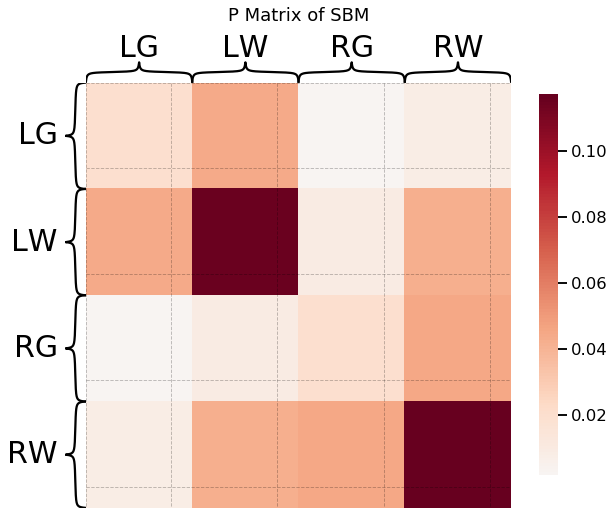

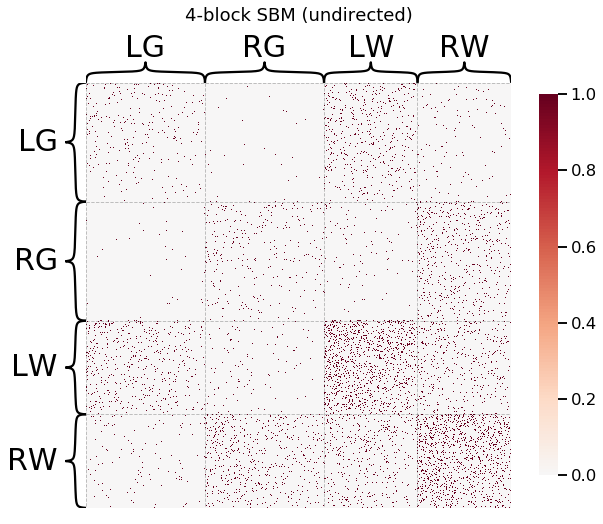

In [3]:
# generate SBM graph
np.random.seed(250)
n_verts = 1000
labels_sbm = int(0.28 * n_verts) * ["LG"] + int(0.22 * n_verts) * ["LW"] + int(0.28 * n_verts) * ["RG"] + int(0.22 * n_verts) * ["RW"]
labels_lr = int(0.28 * n_verts) * [0] + int(0.22*n_verts) * [0] + int(0.28*n_verts) * [1] + int(0.22*n_verts) * [1] #true label
labels_gw = int(0.28 * n_verts) * [0] + int(0.22*n_verts) * [1] + int(0.28*n_verts) * [0] + int(0.22*n_verts) * [1] #true label
P = np.array([[0.020, 0.044, 0.002, 0.009],
              [0.044, 0.115, 0.010, 0.042],
              [0.002, 0.010, 0.020, 0.045],
              [0.009, 0.042, 0.045, 0.117]])
undirected_sbm = sbm([int(0.28 *n_verts),int(0.22 *n_verts),int(0.28 *n_verts),int(0.22 *n_verts)], P)
# visualization
heatmap(P, title='P Matrix of SBM', inner_hier_labels=["LG","LW","RG","RW"])
heatmap(undirected_sbm, title='4-block SBM (undirected)', inner_hier_labels=labels_sbm)

## LSE
We first do LSE, and the figure shows the true 4 clusters on LSE.

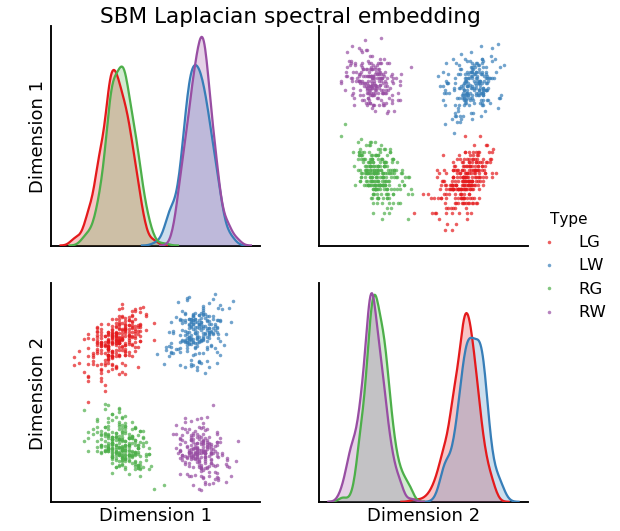

In [4]:
# LSE
lse = LaplacianSpectralEmbed(n_components=2)
lse_Xhat = lse.fit_transform(undirected_sbm)
pairplot(lse_Xhat,labels=labels_sbm,title='SBM Laplacian spectral embedding', height=4)

## Clustering LSE result
We use K-means (Python), Pyclust (Python, based on Gaussian Mixed Model) and mclust (R, based on Gaussian Mixed Model) to cluster the LSE result. All these three methods show Left vs Right hemishpere result. As figures show below.

ARI(LSE,LR):  0.995999996008016
ARI(LSE,GW):  -0.000983610710147623


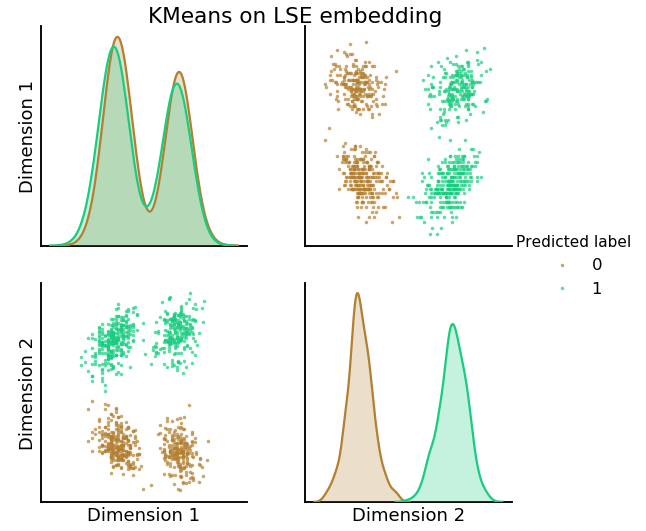

In [5]:
# K-means clustering using LSE
palette_pre = {0:(0.7,0.5,0.2),
               1:(0.1,0.8,0.5)}
lse_kmeans = KMeans(n_clusters=2).fit_predict(lse_Xhat)
lse_ari = adjusted_rand_score(labels_lr, lse_kmeans)
lse_ari_2 = adjusted_rand_score(labels_gw, lse_kmeans)
print("ARI(LSE,LR): ",lse_ari)
print("ARI(LSE,GW): ",lse_ari_2)
pairplot(lse_Xhat,
         labels=lse_kmeans,
         title='KMeans on LSE embedding',
         legend_name='Predicted label',
         height=4,
         palette= palette_pre)

ARI(LSE,LR):  0.995999996008016
ARI(LSE,GW):  -0.000983610710147623


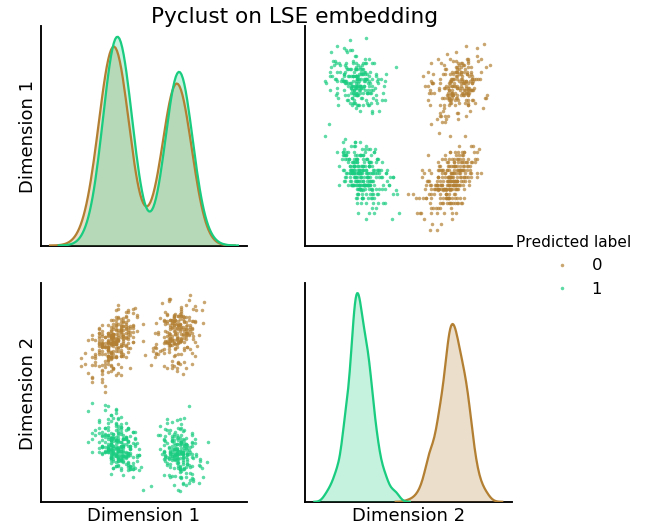

In [6]:
# Pyclust clustering using LSE
py_lse = PyclustCluster(max_components=2).fit(lse_Xhat)
lse_py = py_lse.predict(lse_Xhat)
lse_ari = adjusted_rand_score(labels_lr, lse_py)
lse_ari_2 = adjusted_rand_score(labels_gw, lse_py)
print("ARI(LSE,LR): ",lse_ari)
print("ARI(LSE,GW): ",lse_ari_2)
pairplot(lse_Xhat,
         labels=lse_py,
         title='Pyclust on LSE embedding',
         legend_name='Predicted label',
         height=4,
         palette= palette_pre)

ARI(LSE,LR):  0.995999996008016
ARI(LSE,GW):  -0.000983610710147623


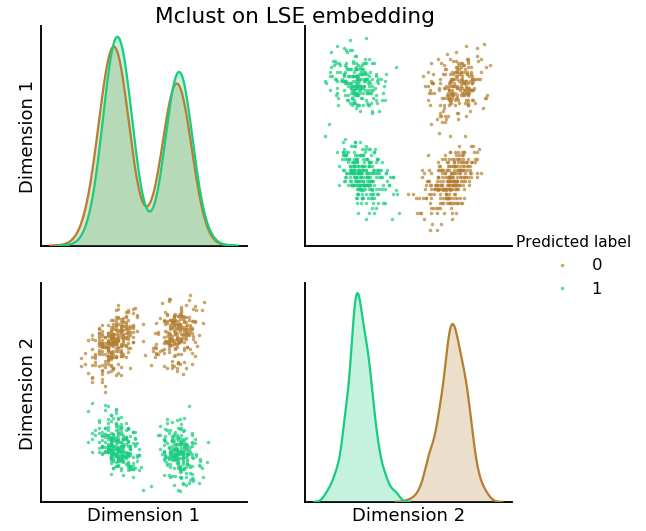

In [7]:
# Mclust clustering using LSE
lse_rm = R_mclust(lse_Xhat)
lse_ari = adjusted_rand_score(labels_lr, lse_rm)
lse_ari_2 = adjusted_rand_score(labels_gw, lse_rm)
print("ARI(LSE,LR): ",lse_ari)
print("ARI(LSE,GW): ",lse_ari_2)
pairplot(lse_Xhat,
         labels=lse_rm,
         title='Mclust on LSE embedding',
         legend_name='Predicted label',
         height=4,
         palette= palette_pre)

## ASE
Then we do ASE, and the figure shows the true 4 clusters on ASE.

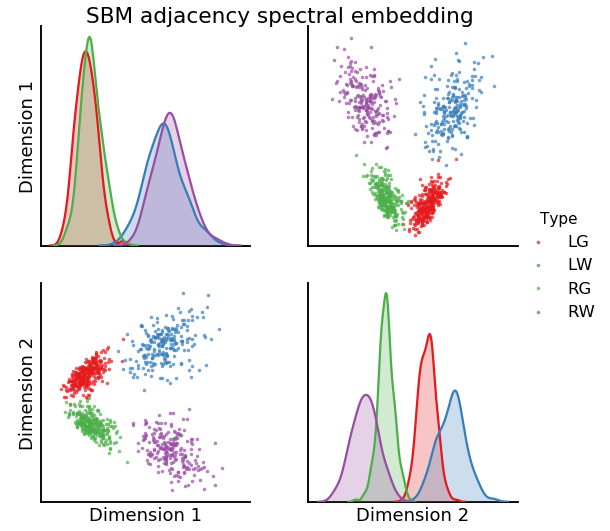

In [8]:
# ASE
ase = AdjacencySpectralEmbed(n_components=2)
ase_Xhat = ase.fit_transform(undirected_sbm)
pairplot(ase_Xhat,labels=labels_sbm, title='SBM adjacency spectral embedding', height=4)

## Clustering ASE result
We use K-means (Python), Pyclust (Python, based on Gaussian Mixed Model) and mclust (R, based on Gaussian Mixed Model) to cluster the ASE results. K-means and Pyclust show Left vs Right hemisphere, while mclust shows Gray vs White matter, which the paper (Ref) suggests.

ARI(ASE,LR):  0.992008
ARI(ASE,GW):  -0.0009875609009248388


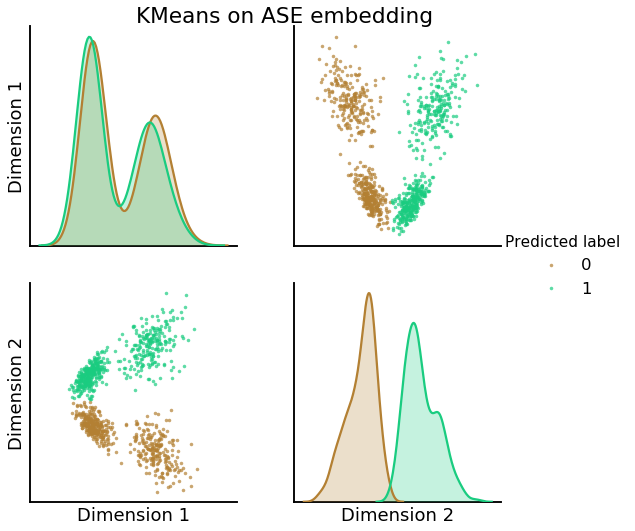

In [9]:
# K-means clustering using ASE
ase_kmeans = KMeans(n_clusters=2).fit_predict(ase_Xhat)
ase_ari = adjusted_rand_score(labels_lr, ase_kmeans)
ase_ari_2 = adjusted_rand_score(labels_gw, ase_kmeans)
print("ARI(ASE,LR): ",ase_ari)
print("ARI(ASE,GW): ",ase_ari_2)
pairplot(ase_Xhat,
         labels=ase_kmeans,
         title='KMeans on ASE embedding',
         legend_name='Predicted label',
         height=4,
         palette= palette_pre)

ARI(ASE,LR):  0.992008
ARI(ASE,GW):  -0.0009875609009248388


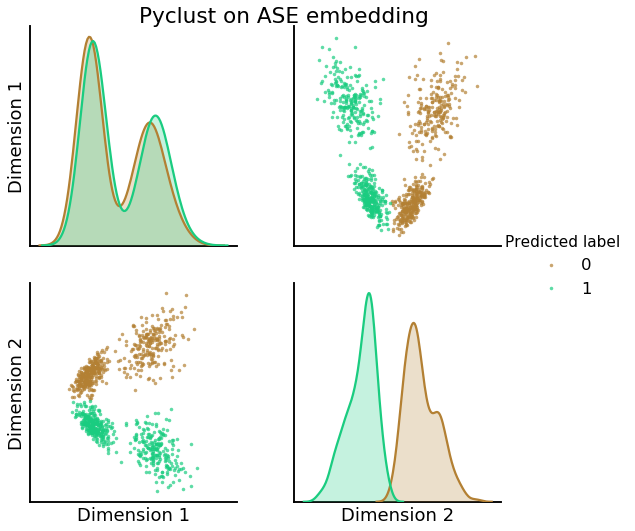

In [10]:
# Pyclust clustering using ASE
py_ase = PyclustCluster(max_components=2).fit(ase_Xhat)
ase_py = py_ase.predict(ase_Xhat)
ase_ari = adjusted_rand_score(labels_lr, ase_py)
ase_ari_2 = adjusted_rand_score(labels_gw, ase_py)
print("ARI(ASE,LR): ",ase_ari)
print("ARI(ASE,GW): ",ase_ari_2)
pairplot(ase_Xhat,
         labels=ase_py,
         title='Pyclust on ASE embedding',
         legend_name='Predicted label',
         height=4,
         palette= palette_pre)

ARI(ASE,LR):  -0.0009849651296524801
ARI(ASE,GW):  0.9880220947622833


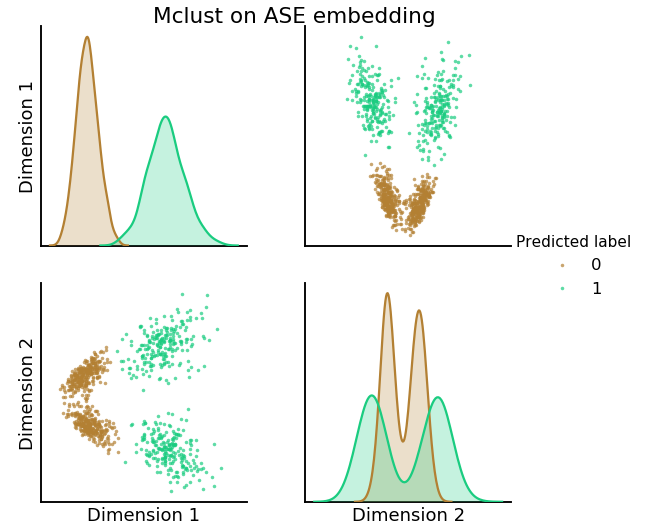

In [11]:
# Mclust clustering using ASE
ase_rm = R_mclust(ase_Xhat)
ase_ari = adjusted_rand_score(labels_lr, ase_rm)
ase_ari_2 = adjusted_rand_score(labels_gw, ase_rm)
print("ARI(ASE,LR): ",ase_ari)
print("ARI(ASE,GW): ",ase_ari_2)
pairplot(ase_Xhat,
         labels=ase_rm,
         title='Mclust on ASE embedding',
         legend_name='Predicted label',
         height=4,
         palette= palette_pre)

## Initialize Pyclust using mclust result
For Pyclust and mclust give different results, we initialize pyclust with mclust result to see what will happen.
As the figure shows below, Pyclust will stay at Gray vs White matter, meaning that gray/white and left/right both are convergence regions of GMM.

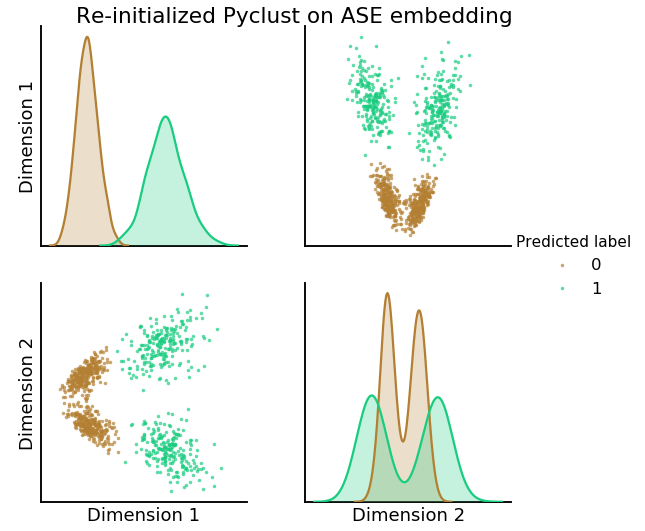

In [12]:
py_ase = PyclustCluster(max_components=2,label_init=ase_rm).fit(ase_Xhat)
ase_py = py_ase.predict(ase_Xhat)
#ari = adjusted_rand_score(label, ase_py)
pairplot(ase_Xhat,
         labels=ase_py,
         title='Re-initialized Pyclust on ASE embedding',
         legend_name='Predicted label',
         height=4,
         palette= palette_pre)